# Cicero Debug

Does not seem to be working with smallpeaks with around 800k peaks with length between 200-300bp.

In [1]:
library(cicero)
library(Matrix)
library(ggplot2)
library(scales)
library(rtracklayer)

Loading required package: monocle3

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignette

## Load Data

In [2]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.overlap.smallpeaks.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 803958

In [113]:
pmat_merged = readMM("../20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.sparse.mm")
pmat_merged = as(pmat_merged, "dgCMatrix")
dim(pmat_merged)

[1]  68916 409052

In [3]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 68916     5

,barcode,sample,umap1,umap2,cells
,<fct>,<fct>,<dbl>,<dbl>,<chr>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA


In [4]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.overlap.smallpeaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 803958      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_97145604_97145864,chr1,97145604,97145864,chr1_97145604_97145864
chr1_7538148_7538363,chr1,7538148,7538363,chr1_7538148_7538363
chr1_93196678_93196894,chr1,93196678,93196894,chr1_93196678_93196894
chr1_187577713_187577913,chr1,187577713,187577913,chr1_187577713_187577913
chr1_53278065_53278265,chr1,53278065,53278265,chr1_53278065_53278265
chr1_177176832_177177032,chr1,177176832,177177032,chr1_177176832_177177032


In [114]:
regions_merged = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.bed")
names(regions_merged) = c("chr", "bp1", "bp2")
regions_merged$site_name <- paste(regions_merged$chr, regions_merged$bp1, regions_merged$bp2, sep="_")
row.names(regions_merged) <- regions_merged$site_name
dim(regions_merged)
head(regions_merged)

[1] 409052      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_10355_10867,chr1,10355,10867,chr1_10355_10867
chr1_41995_42521,chr1,41995,42521,chr1_41995_42521
chr1_46067_46593,chr1,46067,46593,chr1_46067_46593
chr1_48475_48975,chr1,48475,48975,chr1_48475_48975
chr1_51286_52235,chr1,51286,52235,chr1_51286_52235
chr1_58648_59148,chr1,58648,59148,chr1_58648_59148


In [90]:
# sort by coordinate! -- does not seem to be necessary
pmat = pmat[,order(regions$chr, regions$bp1)]
regions = regions[order(regions$chr, regions$bp1), ]

In [115]:
# sort by coordinate! -- does not seem to be necessary
pmat_merged = pmat_merged[,order(regions_merged$chr, regions_merged$bp1)]
regions_merged = regions_merged[order(regions_merged$chr, regions_merged$bp1), ]

In [212]:
# subset 
subset_peaks = (regions$chr=="chr1")&(regions$bp1>20000000)&(regions$bp1<30000000)
sum(subset_peaks)

[1] 4466

In [213]:
pmat_subset = pmat[, subset_peaks]
regions_subset = regions[subset_peaks, ]

In [214]:
dim(pmat_subset)

[1] 68916  4466

## Running Cicero 

In [215]:
# binarize the matrix (could also do outlier removal)
pmat_subset@x[pmat_subset@x > 0] <- 1

In [216]:
subset_cells = Matrix::rowSums(pmat_subset)>100
sum(subset_cells)

[1] 18308

In [217]:
pmat_subset = pmat_subset[subset_cells, ]
metaData_subset = metaData[subset_cells, ]

In [218]:
dim(pmat_subset)

[1] 18308  4466

In [219]:
row.names(pmat_subset) <- row.names(metaData_subset)
colnames(pmat_subset) <- row.names(regions_subset)

In [220]:
input_cds <-  new_cell_data_set(t(pmat_subset),  # need to transpose based on tutorial
              cell_metadata = metaData_subset,
              gene_metadata = regions_subset)

Warning message in new_cell_data_set(t(pmat_subset), cell_metadata = metaData_subset, :
"Warning: gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions."


In [221]:
input_cds <- monocle3::detect_genes(input_cds)

#Ensure there are no peaks included with zero reads
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,] 

In [222]:
umap_df = data.frame(umap_coord1=metaData_subset$umap1, umap_coord2=metaData_subset$umap2)
rownames(umap_df) = rownames(metaData_subset)
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_df, k=500)

Overlap QC metrics:
Cells per bin: 500
Maximum shared cells bin-bin: 449
Mean shared cells bin-bin: 15.4149105239175
Median shared cells bin-bin: 0



In [223]:
cicero_cds

class: cell_data_set 
dim: 4466 1193 
metadata(1): cds_version
assays(1): counts
rownames(4466): chr1_20008464_20008742 chr1_20020881_20021118 ...
  chr1_29991094_29991330 chr1_29991378_29991578
rowData names(5): chr bp1 bp2 site_name num_cells_expressed
colnames(1193): agg18280 agg12814 ... agg3863 agg16996
colData names(3): agg_cell Size_Factor num_genes_expressed
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [162]:
# temp = assay(cicero_cds)[rownames(cicero_cds) %in% c("chr1_26772735_26773035", "chr1_26969199_26969399"),  ]

In [193]:
temp = assay(cicero_cds)[rownames(cicero_cds) %in% c("chr1_26771173_26773185", "chr1_26969049_26969549"),  ]

In [194]:
temp = data.frame(as.matrix(temp))

In [195]:
dim(temp)

[1]   2 765

In [196]:
cor(t(temp), method='spearman')

,chr1_26771173_26773185,chr1_26969049_26969549
chr1_26771173_26773185,1.0000000,0.5191431
chr1_26969049_26969549,0.5191431,1.0000000


In [167]:
head(temp)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"


agg15028,agg10875,agg10251,agg11144,agg7642,agg3573,agg14822,agg243,agg10075,agg5840,⋯,agg8736,agg765,agg3942,agg11002,agg13865,agg638,agg14427,agg8659,agg6347,agg1519
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [168]:
hg38.chrom.sizes = read.table("~/genomes/hg38/hg38.chrom.sizes")

In [ ]:
cur_genome = subset(hg38.chrom.sizes, V1 == "chr1")
cur_genome$V2[1] <- 30000000
conns <- run_cicero(cicero_cds, cur_genome)

In [252]:
distance_parameters <- estimate_distance_parameter(cicero_cds, window=500000,
                                  maxit=100, sample_num = 100,
                                   distance_constraint = 250000,
                                   distance_parameter_convergence = 1e-22,
                                   genomic_coords = cur_genome,
                                   max_elements = 200)

Warning message in estimate_distance_parameter(cicero_cds, window = 5e+05, maxit = 100, :
"Could not calculate sample_num distance_parameters (27 were calculated) - see documentation details"


In [253]:
mean_distance_parameter <- mean(unlist(distance_parameters))

In [254]:
mean_distance_parameter

[1] 2

In [248]:
cicero_out <- generate_cicero_models(cicero_cds,
                           distance_parameter = 1,
                           window = 500000,
                           max_elements=400,
                           genomic_coords = cur_genome)

In [249]:
conns <- assemble_connections(cicero_out, silent=F)

[1] "Successful cicero models:  41"
[1] "Other models: "

Zero or one element in range 
                          79 
[1] "Models with errors:  0"


In [250]:
high_conns = conns[conns$coaccess > 0.1, ]
high_conns = high_conns[!is.na(high_conns$coaccess), ]
high_conns$distance = abs(as.integer(lapply(strsplit(as.character(high_conns$Peak1), "_"), "[[", 2)) - as.integer(lapply(strsplit(as.character(high_conns$Peak2), "_"), "[[", 2)))

In [251]:
dim(high_conns)

[1] 582802      4

## Visualize

In [229]:
gencode.basic.hg38 = import.gff(gzfile("../../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gene_anno <- data.frame(gencode.basic.hg38)
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]


# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqnames
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_name
gene_anno$symbol <- gene_anno$gene_name

Warning message in readGFF(filepath, version = version, filter = filter):
"connection is not positioned at the start of the file, rewinding it"


In [230]:
dim(gene_anno)

[1] 1603274      30

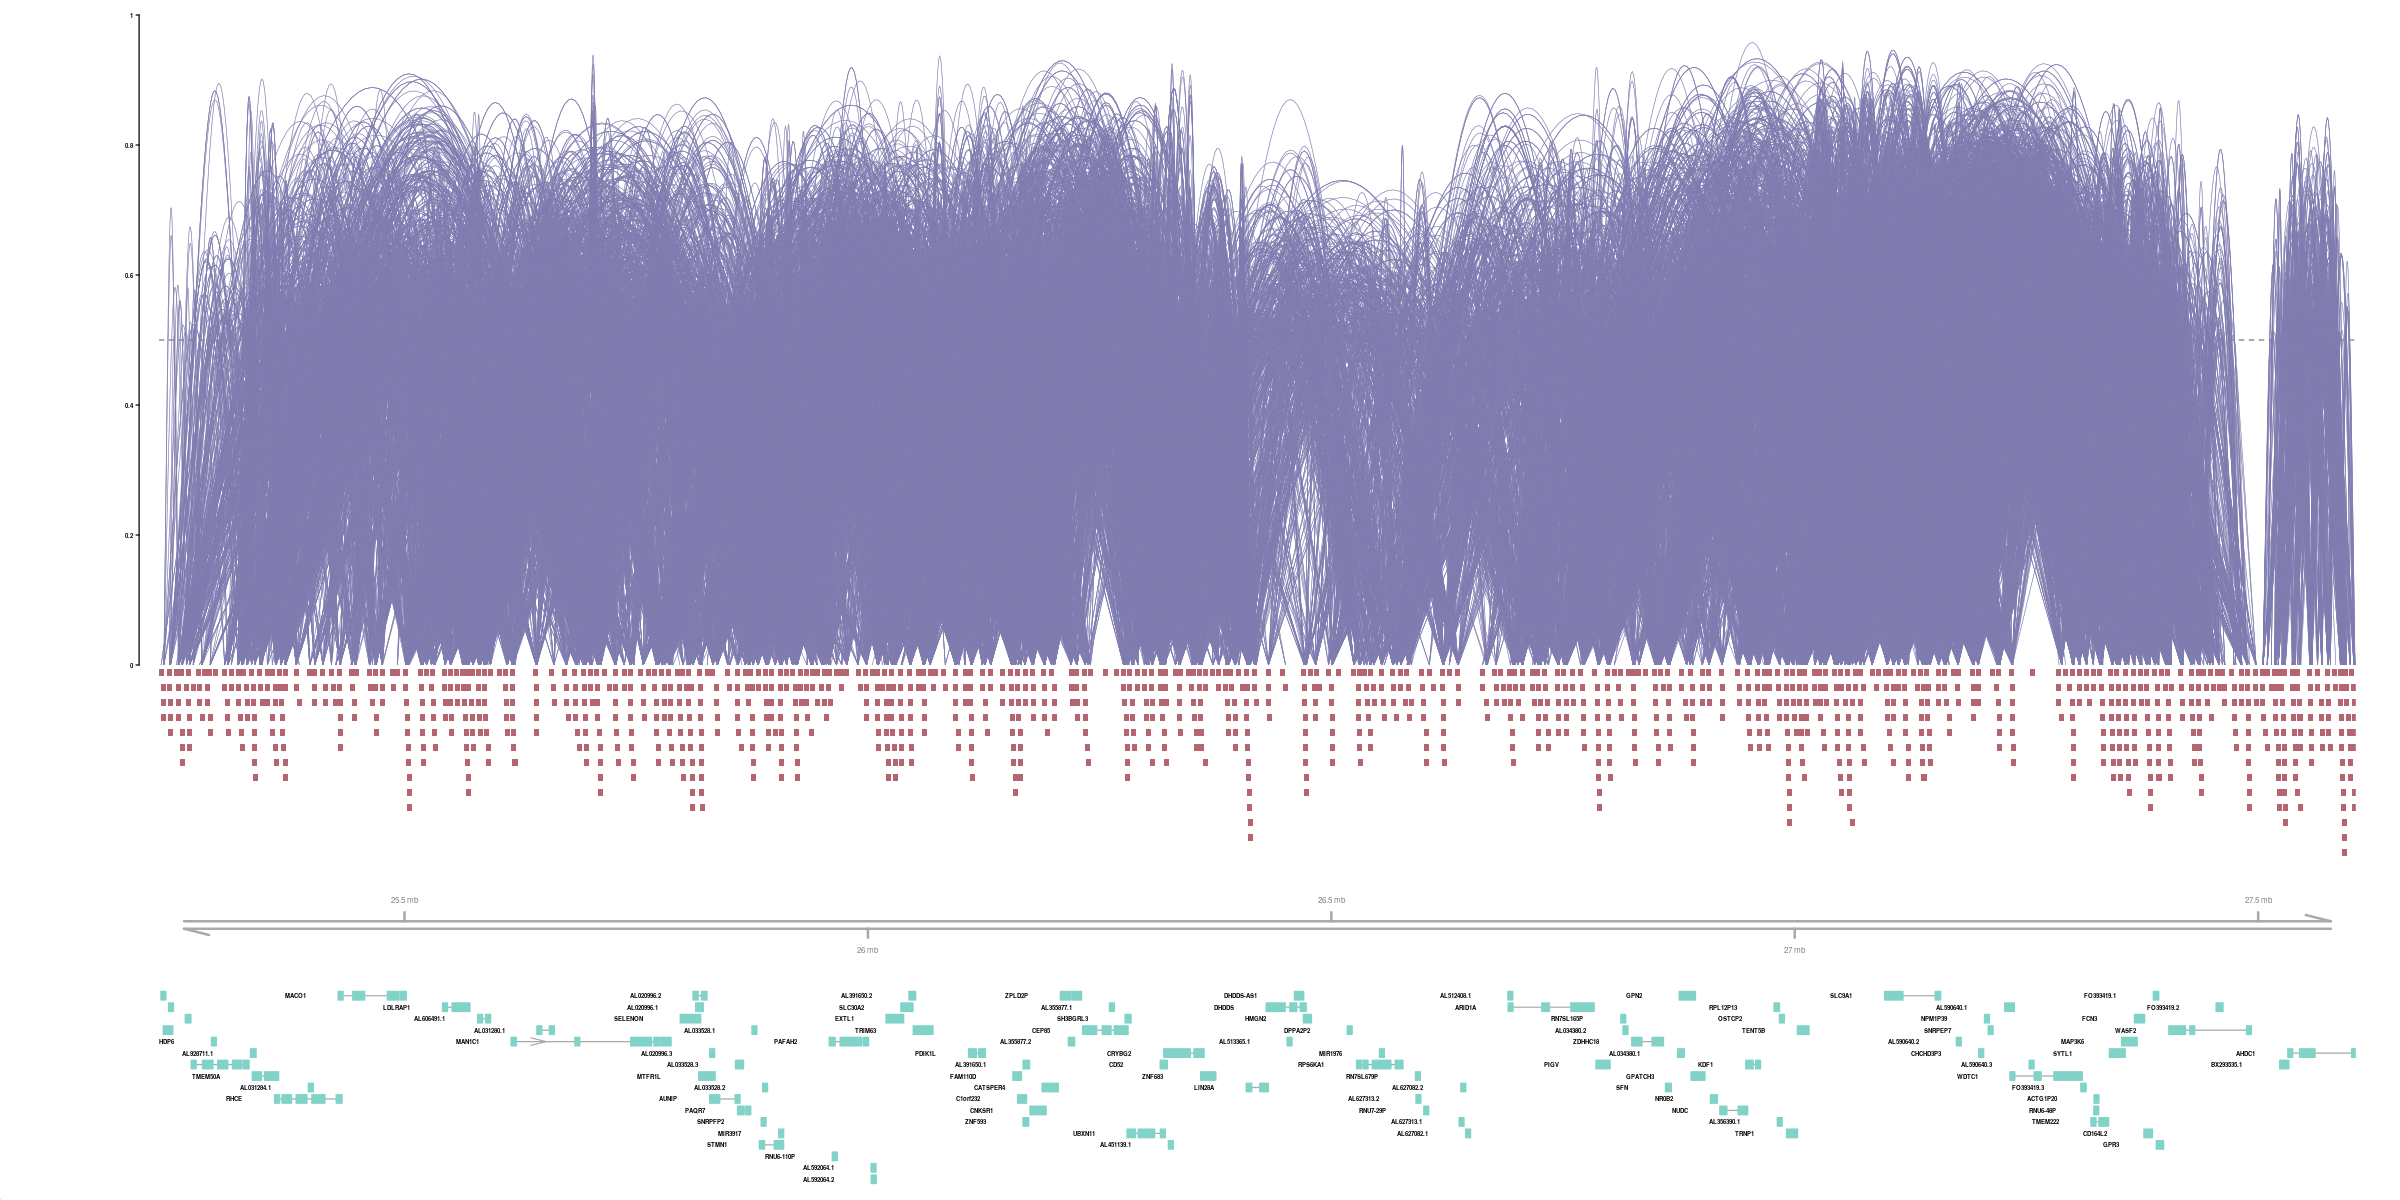

In [247]:
options(repr.plot.width = 20, repr.plot.height = 10)

plot_connections(high_conns[high_conns$distance>10000,], "chr1", 25235185, 27605310,
                 gene_model = gene_anno, 
                 coaccess_cutoff = .5, 
                 connection_width = .5, 
                 collapseTranscripts = "longest" )

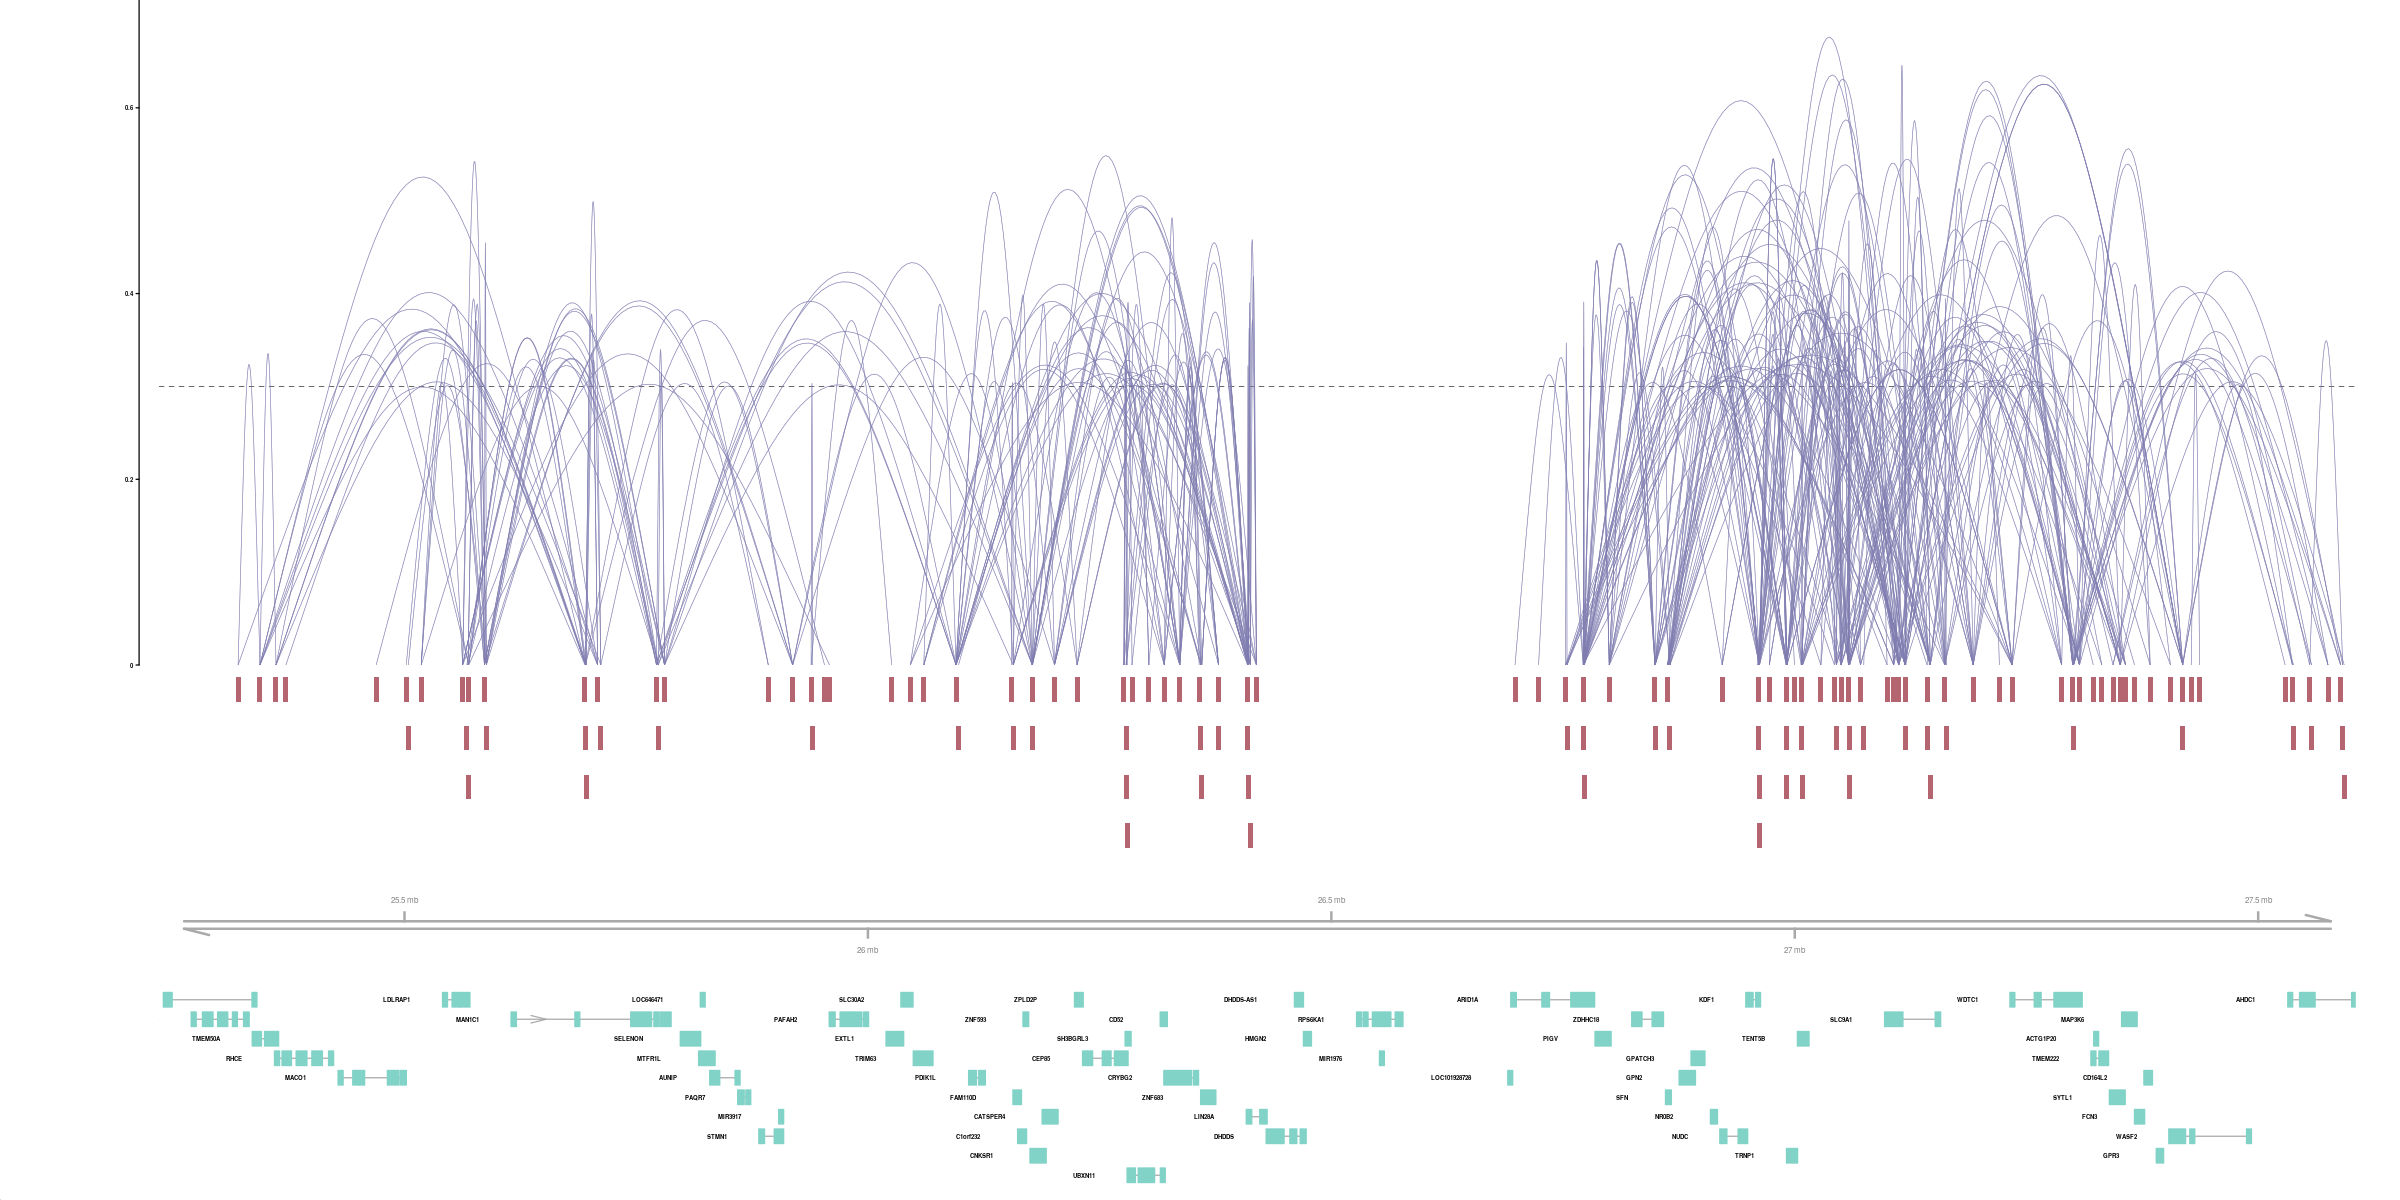

In [269]:
# old run (20200417_default_20200220_n74838)
options(repr.plot.width = 20, repr.plot.height = 10)

plot_connections(high_conns[high_conns$distance>1000,], "chr1", 25235185, 27605310,
                 gene_model = gene_anno, 
                 coaccess_cutoff = .3, 
                 connection_width = .5, 
                 collapseTranscripts = "longest" )

---
Increasing `max_elements` does the job for range 200-300bp peaks since the density of peaks is higher as peaks are smaller.